In [245]:
import numpy as np
from importlib import reload
from scipy import signal

import plotting_tools as pt
import utils
import dsi
utils = reload(utils)
pt = reload(pt)
dsi = reload(dsi)

import dill as pickle
import sys
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../RKLM_Python/')

from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
from matplotlib import rc

# activate latex text rendering
rc('text', usetex=True)

In [246]:
Nx, Ny = 151, 60
# Nx, Ny = 1201, 80
ib = False

N = 1
fac = 1.0 # how many plots?

def load(Nx,Ny,et,test):
    if test == 'mark':
        base_fn = 'output_mark_wave'
    elif test == 'lamb':
        base_fn = 'output_lamb_wave'
    pydir = '../%s/' %base_fn

    tc = utils.test_case(base_fn, pydir, Nx, Ny, et)
    tags = tc.get_tag_dict()
    
    return tc, tags

i2 = (slice(2,-2),slice(2,-2))

In [247]:
def get_ens(tc, times, sfx , diff, attribute, tag, NIDX):
    idx = 0 if tag == 'ic' else -1
    times = [0] if tag == 'ic' else times
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=diff, tag=tag, inner=False,load_ic=True)[idx]

    label = sfx + '_' + attribute
    return label, ens.T[:NIDX,:]

def get_ens_all(tc, times, sfx , diff, attribute, tag, NIDX):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=diff, tag=tag, inner=True,load_ic=True)
    ens = ens[:,:,:NIDX]
    print(ens.shape)
    return ens

def get_arr(typ, times, NIDX, tp='half', test='mark', et=8000.0):
    sfx1 = '%s' %typ
    if ib: sfx1 = '%s_ib-0' %sfx1
    print(sfx1, typ)

    tc, tags = load(Nx,Ny,et,test)
    if tp=='afs':
        tag = 'after_full_step'
    else:
        tag = tp

    # load pickled instances of data used in simulation
    fn_pickle = tc.get_filename(N,sfx1,format='dat')
    path_pickle = tc.get_path(fn_pickle)

    print(path_pickle)
    file = open(path_pickle,'rb')
    ud = pickle.load(file)
    mpv = pickle.load(file)
    dap = pickle.load(file)
    elem = pickle.load(file)
    file.close()

    S0 = (ud.stratification(elem.y)).reshape(-1,1)[:NIDX]
    
#     attributes = ['rhoX','rhou', 'rhov', 'rhoY', 'p2_nodes']
    attributes = ['rhov', 'rhoY', 'p2_nodes']
    _, rho = get_ens(tc, times, sfx1, diff, 'rho', tag, NIDX)
    la = r''
    if 'best' in typ:
        la += r'\textbf{CS}'
    elif 'imbal' in typ:
        la += r'\textbf{NS}'
    else:
        la += r''
#     la = la + '_' + typ
    ret = []
    
#     rho_pl = rho[i2] #* ud.rho_ref
#     ret.append([rho_pl,la + r' ($\rho$)'])
    _, rhou = get_ens(tc, times, sfx1, diff, 'rhou', tag, NIDX)
    u = rhou / rho
    u = u[i2]
    ret.append([u, r' $u^\prime$'])
    
    for attribute in attributes:
        _, aa = get_ens(tc, times, sfx1, diff, attribute, tag, NIDX)
        if attribute == 'rhoY':
            la_curr = la + r' $\Theta^\prime$'
        elif attribute == 'rhov':
            la_curr = la + r' $w^\prime$'
        elif attribute == 'rhou':
            la_curr = la + r' $u^\prime$'
        elif attribute == 'rhoX':
            la_curr = la + r' $\chi^\prime$'
        else:
            la_curr = la + r' $\pi^\prime$'
        
        if attribute == 'rhoY':
            aa = aa / rho
            aa -= S0
            aa = aa[i2] #* ud.T_ref
        elif attribute == 'rhou':
            aa = aa / rho
            aa = aa[i2] #* ud.u_ref
        elif attribute == 'rhov':
            aa = aa / rho
            aa = aa[i2] #* ud.u_ref
        elif attribute == 'rhoX':
            aa = aa / rho
            aa = aa[i2] #/ ud.T_ref
        elif attribute == 'p2_nodes':
            aa = aa[i2]
            
        ret.append([aa,la_curr])
    
    return np.array(ret), (ud,mpv), tc

In [258]:
l_typ = 'WINDOW_STEP'
diff = False

attr_labels = pt.labels()

typ1 = 'debug_ic_test_S400_noom_a05'
typ1 = 'bdl_run_S400_a05'

def file_namer(ttype, sttype):
    if len(ttype) > 0:
        ttype += '_'
    typ1 = 'debug_ic_%som_%s' %(ttype,sttype)
    typ2 = 'debug_ic_%snoom_%s' %(ttype,sttype)
    return typ1, typ2

tp ='afs'
tag = 'after_full_step'
time_unit = 's'

long = 'long' in typ1 or 'short' in typ1

# l_typ = 'TIME'
# times0 = np.arange(0.0,720.0+0.6,0.6)[1:50]
# times0 = np.arange(0.0,720.0+0.01,0.01)[1:50]
times0 = np.arange(31)
    
NIDX = int(Ny/4+4)
print('NIDX = %i' %NIDX)
_,ics,tc = get_arr(typ1,times0, NIDX, tp=tp, et=720.0)
ud, mpv = ics[0], ics[1]
_ = get_ens_all(tc, times0, typ1, False, 'rho', tag, NIDX)[:]

t_axs = np.append(0,times0)

print(times0)
phys_time = tc.t_arr

if '_om_' in typ1:
    tcase = 'w_omega'
    tstr = r'7.292 \times 10^{-5}'
elif '_noom_' in typ1:
    tcase = 'wo_omega'
    tstr = r'0.0'
else:
    tcase = 'a05'
    tstr = '%.6f' %(ud.coriolis_strength[2] / ud.t_ref)

lrho = np.arange(0.32,0.96+0.08,0.08)
lrhoX = np.arange(-0.00032,0.00032+0.00008,0.00008)
# lrhoX = [None]
lu = np.arange(-0.004,0.004+0.001,0.001)
lv = np.arange(-0.00060,0.00060+0.00015,0.00015)
lv = np.arange(-0.0008,0.0008+0.0002,0.0002)
lrhoY = np.arange(-0.0006,0.0006+0.00015,0.00015)
lp2n = np.arange(-0.001,0.00125,0.00025)
lvls = [lrho,lrhoX,lu,lv,lrhoY,lp2n]
lvls = [lu,lv,lrhoY,lp2n]

lu = np.arange(-0.004/2,0.004/2+0.0005,0.0005)
lv = np.arange(-0.0008/2,0.0008/2+0.0001,0.0001)
lrhoY = np.arange(-0.0006/2,0.0006/2+0.000075,0.000075)
lp2n = np.arange(-0.001,0.00125,0.00025)
lvls = [lu,lv,lrhoY,lp2n]

for idx,time in enumerate(times0):
#     print(time)
    tp = 'ic' if time == 0 else 'afs'
    print(idx, tp)
    aa2,ics,_ = get_arr(typ1,[time], NIDX, tp=tp, et=720.0)
    ud, mpv = ics[0], ics[1]
#     if long:
    ct = 0.0 if time == 0 else time
#     else:
#         ct = 0.0 if time == 0 else t_axs[time]

    pl_lst = aa2
    pl = pt.plotter(pl_lst,ncols=2,figsize=(32*fac,20*fac),sharey=False, fontsize=32)
    x_axs = np.array(np.linspace(ud.xmin,ud.xmax,7))
    # y_axs = [-0.5,-0.25,0.0,0.25,0.5]
    y_axs = np.array(np.linspace(ud.ymin,ud.ymax,6))

    x_axs = np.around(x_axs,3)
    y_axs = np.around(y_axs/4,1)

    x_loc = np.linspace(0,Nx-1,7)
    y_loc = np.linspace(0,Ny/4-1,6)
    
    print(y_loc, y_axs)
    x_label = r'x [$\times 10$ km]'
    y_label = r'y [$\times 10$ km]'

    pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
    
    if 'rsts' in typ1:
        time_unit = 's'
        tu = ud.t_ref
        stitle = r'$\Omega_y = %s s^{-1}$, time = %.2f %s' %(tstr, ct*tu, time_unit)
    elif 'hrs' in typ1 or long or 'min' in typ1 or 'vlarge' in typ1:
        time_unit = 'hrs'
        tu = ud.t_ref/3600
        stitle = r'$\Omega_y = %s s^{-1}$, time = %.2f %s' %(tstr, ct*tu, time_unit)
    else:
        tu = ud.t_ref#/3600
        stitle = r'$\Omega_y = %s s^{-1}$, time-step = %i, time = %.2f %s' %(tstr, idx, phys_time[idx]*tu, time_unit)
    _ = pl.plot(method='contour', lvls=lvls, suptitle=stitle, rect=[0, 0.03, 1, 0.95])

    pl.save_fig('./output_mark/lamb_%s_%.3d' %(tcase,ct), format='.png')
    plt.close()

NIDX = 19
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(32, 151, 19)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
0 ic
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/git-projects/RKLM_Reference/visualiser_debugger/plotting_tools.py:168: UserWarning: No contour levels were found within the data range.
  im = cax.contour(arr,linewidths=1.0,colors='k',levels=lvls)


1 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]
2 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


3 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


4 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


5 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]
6 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


7 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


8 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


9 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


10 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


11 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


12 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


13 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


14 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


15 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


16 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


17 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


18 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


19 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


20 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


21 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


22 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


23 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


24 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


25 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


26 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


27 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


28 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


29 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


30 afs
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
[ 0.   2.8  5.6  8.4 11.2 14. ] [0.  0.4 0.8 1.2 1.6 2. ]


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S400_a05
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
bdl_run_S400_a05 bdl_run_S400_a05
../output_mark_wave/output_mark_wave_ensemble=1_151_60_720.000000_bdl_run_S400_a05.dat
NIDX = 19
(51, 151, 19)


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(51, 151, 19)
(51, 151, 19)
(51, 151, 19)
(51, 152, 20)
(51, 151, 19)
(51, 151, 19)
23349.32438171927 70168.30607501477


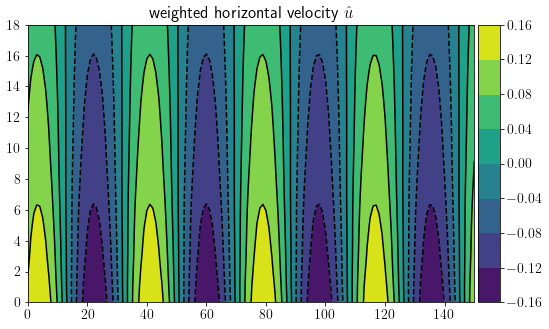

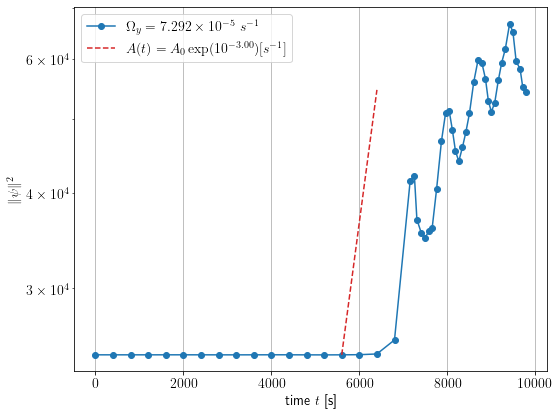

In [256]:
from matplotlib.ticker import (FixedLocator)
from matplotlib import ticker

from numpy import linalg as la

l_typ = 'WINDOW_STEP'
diff = False

attr_labels = pt.labels()

def file_namer(ttype, sttype):
    if len(ttype) > 0:
        ttype += '_'
    typ1 = 'debug_ic_%som_%s' %(ttype,sttype)
    typ2 = 'debug_ic_%snoom_%s' %(ttype,sttype)
    return typ1, typ2

typ2 = 'debug_ic_noom_hrs'
typ1 = 'debug_ic_om_hrs'

# sfx = '_S800'
typ1 = 'debug_ic_test%s' %sfx
typ2 = 'debug_ic_test%s' %sfx

typ1 = 'bdl_run_S400_a05'
typ2 = typ1

print(typ1)

Nx, Ny = 151, 60
et = 720.0
tc, tags = load(Nx,Ny,et,'mark')

nts = 50
times0 = np.arange(nts)
times1 = np.arange(nts)

long = 'long' in typ1 or 'short' in typ1 or 'min' in typ1
short = 'short' in typ1

if long:
#     l_typ = 'TIME'
#     times1 = np.arange(0.0,720.0+0.6,0.6)[1:51]
#     times1 = np.arange(0.0,720.0+0.01,0.01)[1:11]
#     times2 = times1
    pass

# tp = 'ic'
tp = 'ic' if times1[0] == 0 else 'afs'
attribute = 'rhou'
tag = 'after_full_step'

NIDX = int(Ny/4+4)
if 'hrs' in typ1 or long or 'vlarge' in typ1:
    _,_,tc1 = get_arr(typ1,times1, tp=tp, et=720.0)
    _,_,tc2 = get_arr(typ2,times2, tp=tp, et=720.0)
    tt1 = times1
    tt2 = times2
else:
    _,ics1,tc1 = get_arr(typ1,times0, NIDX, tp=tp, et=720.0)
    _,ics2,tc2 = get_arr(typ2,times0, NIDX, tp=tp, et=720.0)
    tt1, tt2 = times0, times0
    
ud, mpv = ics1
print("NIDX = %i" %NIDX)
rhos = get_ens_all(tc1, tt1, typ1, False, 'rho', tag, NIDX)[:]

arrs_rhou = get_ens_all(tc1, tt1, typ1, False, attribute, tag, NIDX)[:]
arrs_rhov = get_ens_all(tc1, tt1, typ1, False, 'rhov', tag, NIDX)[:]
arrs_rhoY = get_ens_all(tc1, tt1, typ1, False, 'rhoY', tag, NIDX)[:]
arrs_pi = get_ens_all(tc1, tt1, typ1, False, 'p2_nodes', tag, NIDX+1)[:]

rhobar = mpv.HydroState.rho0[:NIDX]#[2:-2]
# rhobar = 1.0
# ud.rho_ref = 1.0
uhat = arrs_rhou / rhos * rhobar**0.5 * (ud.u_ref * np.sqrt(ud.rho_ref))
vhat = arrs_rhov / rhos * rhobar**0.5 * (ud.u_ref * np.sqrt(ud.rho_ref))
Nfq = ud.Nsq_ref**0.5
g = ud.gravity_strength[1] * ud.u_ref / ud.t_ref
Ybar = mpv.HydroState.Y0[:NIDX]#[2:-2]
Yhat = g / Nfq * (rhobar**0.5 * np.sqrt(ud.rho_ref)) / Ybar * (arrs_rhoY / rhos - Ybar)
p2c = np.array([signal.fftconvolve(mem,[[1,1],[1,1]], mode='valid')/4.0 for mem in arrs_pi])
C = (ud.u_ref * np.sqrt(1.4/ud.Msq))
p2hat = 1.0 / C * (rhobar**0.5 * np.sqrt(ud.rho_ref)) * Ybar * p2c * ud.T_ref #* ud.Msq

# rhobar = mpv.HydroState.rho0[:NIDX]#[2:-2]

# uhat = arrs_rhou / rhos * rhobar**0.5
# vhat = arrs_rhov / rhos * rhobar**0.5
# Nfq = ud.Nsq_ref**0.5
# g = ud.gravity_strength[1] * ud.u_ref / ud.t_ref
# Ybar = mpv.HydroState.Y0[:NIDX]#[2:-2]
# Yhat = g / Nfq * (rhobar**0.5 * np.sqrt(ud.rho_ref)) / Ybar * (arrs_rhoY / rhos - Ybar)
# p2c = [signal.fftconvolve(mem,[[1,1],[1,1]], mode='valid') for mem in arrs_pi]
# C = (ud.u_ref / ud.Msq**0.5)
# p2hat = 1.0 / C * (rhobar**0.5 * np.sqrt(ud.rho_ref)) * Ybar * p2c * ud.T_ref# * ud.Msq

t_axs1 = np.array(tc1.t_arr)

arrs_noom = get_ens_all(tc2, tt2, typ2, False, attribute, tag, NIDX)[:]
rhos_noom = get_ens_all(tc2, tt2, typ2, False, 'rho', tag, NIDX)[:]
t_axs2 = np.array(tc2.t_arr)

# if long:
#     t_axs1 = np.append(0,times1)
#     t_axs2 = np.append(0,times2)
#     print(t_axs1)

# print(t_axs1, t_axs2)

# plt.figure()
# plt.imshow(uhat[10][...].T, origin='lower')
# plt.colorbar()
# plt.show()
# pl_lst = [[rhos[10][...].T,r'background density $\bar{\rho}$']]
# pl_lst = [[uhat[10][...].T,'horizontal velocity $u^\prime$']]
pl_lst = [[uhat[10][...].T,'weighted horizontal velocity $\hat{u}$']]
pl = pt.plotter(pl_lst,ncols=1,figsize=(8*fac,5*fac),sharey=False)
_ = pl.plot(method='contour', lvls=None)
pl.save_fig('./output_mark/background_rho', format='.png')

res = []
res_noom = []
for idx, arr in enumerate(arrs_rhou):
#     u = arr / rhos[idx]
    u = uhat[idx]
    v = vhat[idx]
    Y = Yhat[idx]
    p = p2hat[idx]
#     nnorm = np.array([u])
    nnorm = np.array([u,v,Y,p])
#     nnorm = u+v+Y+p
#     nnorm = u**2 + v**2 + Y**2 + p**2
#     nnorm = u + v + Y + p
#     print(u.shape)
    res.append(0.5*la.norm(nnorm)**2)
#     res.append(nnorm)
    
for idx, arr in enumerate(arrs_noom):
    u_noom = arr / rhos_noom[idx]
    res_noom.append(u_noom.max())
    
res = np.array(res)
res_noom = np.array(res_noom)

fig = plt.figure(figsize=(8,6))
fig.add_subplot(111)
ax = plt.gca()

# t_axs = t_axs[:nts+1]
tt = t_axs1[:80]* ud.t_ref #/ 3600
# print(tt)
# print(res.shape)
# print(tt.shape)
hrs = 'hrs' in typ1 or 'vlarge' in typ1
vl = 'vlarge' in typ1
tu = ud.t_ref / 3600 if (hrs or (long and not short)) else ud.t_ref
# ax.semilogy(t_axs1*tu, res*ud.u_ref, '-', label=r'$\Omega_y = 7.292 \times 10^{-5}~s^{-1}$')
ax.semilogy(t_axs1*tu, res, '-o', label=r'$\Omega_y = 7.292 \times 10^{-5}~s^{-1}$')
# ax.semilogy(t_axs2*tu, res_noom*ud.u_ref, 'C2-', label=r'$\Omega_y = 0.0~s^{-1}$')

nexp = 3.0
def fth(t):
    return (res[res.argmin()+1].min()*np.exp(10**(-nexp)*t))

nexp1 = 2.2
def fth1(t):
    return (res[res.argmin()]*np.exp(10**(-nexp1)*t))

tty = fth(tt)
tty1 = fth1(tt)
tt += (t_axs1*tu)[np.argmin(res)+1]
# tt += 4500
lls = 3
tty = tty[:lls]
lls1 = 4
tty1 = tty1[:lls1]
tto = np.copy(tt)
tt = tt[:lls]

ax.semilogy(tt, tty, 'C3--', label=r'$A(t) = A_0 \exp(10^{-%.2f})[s^{-1}]$' %nexp)
# ax.semilogy(tt+400, tty, 'C3--')
# ax.semilogy(tt+820, tty, 'C3--')

# tt1 = tto[:lls1] + 0
# ax.semilogy(tt1, tty1, 'C2--', label=r'$A(t) = A_0 \exp(10^{-%.2f})[s^{-1}]$' %nexp1)

formatter = ticker.ScalarFormatter()
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter)
if hrs:
    pos = np.array([0.1,0.5,1.0,5.0,10.0])
    y_locator = FixedLocator(pos)
    ax.yaxis.set_major_locator(y_locator)
    ax.set_ylim([0.1,15.25])
    ax.set_xlim([0.0,20.0])
#     ax.set_ylim([0.1,0.2])
#     ax.set_xlim([0.0,1.0])
elif 'min60' in typ1:
#     pass
    pos = np.array([0.1,0.5,1.0,5.0])
    y_locator = FixedLocator(pos)
    ax.yaxis.set_major_locator(y_locator)
    ax.set_ylim([0.1,10.0])
    ax.set_xlim([0.0,60.0])
elif long:
    pass
# elif len(times0) > 150 and not hrs:
#     pos = np.array(np.arange(1.2,2.1,0.1))*0.1
#     y_locator = FixedLocator(pos)
#     ax.yaxis.set_major_locator(y_locator)
#     ax.yaxis.set_minor_locator(FixedLocator([]))
#     ax.set_ylim([0.12,0.208])
#     ax.set_xlim([0.0,200.0])
# else:
#     pos = np.array(np.arange(1.362,1.378,0.002))*0.1
#     y_locator = FixedLocator(pos)
#     ax.yaxis.set_major_locator(y_locator)
#     ax.yaxis.set_minor_locator(FixedLocator([]))
#     ax.set_xlim([0.0,10.0])
    
# ax.set_xlim([0.0,1.0])
        
# test = (res*ud.u_ref * kGam * Omega)**0.5
# plt.plot(t_axs * ud.t_ref / 3600, test, '-')

# print((t_axs*ud.t_ref)[-1])

# plt.plot(times0 * dt * ud.t_ref, fth(times0 * dt * ud.t_ref))
ymin, ymax = plt.gca().get_ylim()
print(ymin, ymax)
# plt.ylim([-0.2,12.0])
# plt.ylim([1.37e-3,1.38e-3])
# plt.ylim([1.435e-3,1.438e-3])
ax.set_ylabel(r'$\Vert \psi \Vert^2$')
t_units = 'hrs' if (hrs or (long and not short)) else 's'
ax.set_xlabel("time $t$ [%s]" %t_units)
ax.grid()
ax.legend()
plt.tight_layout()
plt.savefig('output_mark/plot.pdf')
# plt.savefig('output_mark/%i_%i%s/plot_psi.pdf' %(int(Nx-1),Ny,sfx))
plt.show()

In [250]:
A = [1,2,3,4,5]
B = [6,7,8,9,0]
for a in zip(A,B):
    print(a)

(1, 6)
(2, 7)
(3, 8)
(4, 9)
(5, 0)
